# Notebook for running MSRE calculations directly from a CAD drawing
This notebook show an example of running computations of a model of the Moten Salt Reactor Experiment of MSRE in short.
The model itself has been generated from tehe original drawings from Oak Ridge National lab 

The simulation backend is run using the Open Source Monte Carlo particle transport code OpenMC (https://openmc.org), through its' python interface.

## The (obvious) 1st step is to import the OpenMC python interface

In [1]:
import openmc

Next we define a set of materials objects that form the core of the MSRE, graphite,  hastelloy N / inor-8, inconel, the fuel salt, and helium. Lastly these are exported to am OpenMC-xml control file.

In [2]:
graphite=openmc.Material(name='graphite')
graphite.add_element('C',1.0,'ao')
graphite.set_density('g/cc',2.26)

#Hastelloy N / INOR-8 nominal material composition from
#ORNL-TM-4189
inor=openmc.Material(name='inor')
inor.add_element('Ni',0.72)
inor.add_element('Mo',0.16)
inor.add_element('Cr',0.07)
inor.add_element('Fe',0.05)
inor.set_density('g/cc',9)

# LiF,BeF2,UF4,ZrF4 [0.67,0.23,0.05,0.0079] mol % @ 33% enrichment 
molar_comp={'LiF':0.67,'BeF2':0.23, 'ZrF4':0.05, 'UF4':0.0079}
enrichment=0.3333
salt=openmc.Material(name='salt')
salt.add_element('F',molar_comp['LiF']*1/2+molar_comp['BeF2']*2/3+molar_comp['ZrF4']*4/5+molar_comp['UF4']*4/5,'ao')
salt.add_nuclide('Li7',molar_comp['LiF']*1/2,'ao')
salt.add_element('Be',molar_comp['BeF2']*1/3,'ao')
salt.add_element('Zr',molar_comp['ZrF4']*1/5,'ao')
salt.add_nuclide('U235',enrichment*molar_comp['UF4']*1/5,'ao')
salt.add_nuclide('U238',(1-enrichment)*molar_comp['UF4']*1/5,'ao')
salt.set_density('g/cc',2.2)

# The natural isotopes have been used for this alloy
# The density is set to that of Ni.
inconel=openmc.Material(name='inconel')
inconel.add_element('Ni',0.72,'ao')
inconel.add_element('Cr',0.20,'ao')
inconel.add_element('Fe',0.08,'ao')
inconel.set_density('g/cc',8.9)

helium=openmc.Material(name='helium')
helium.add_nuclide('He4',1.0,'ao')
helium.set_density('g/cc',1.0e-4)

materials=openmc.Materials([helium,salt,graphite,inconel,inor])
materials.export_to_xml()

As a control we can inspect the materials object. Notice how OpenMC has in the revant cases expanded our material definition to consist the naturally occurring  isotope concentrations.

In [3]:
materials

[Material
 	ID             =	5
 	Name           =	helium
 	Temperature    =	None
 	Density        =	0.0001 [g/cc]
 	Volume         =	None [cm^3]
 	Depletable     =	False
 	S(a,b) Tables  
 	Nuclides       
 	He4            =	1.0          [ao],
 Material
 	ID             =	3
 	Name           =	salt
 	Temperature    =	None
 	Density        =	2.2 [g/cc]
 	Volume         =	None [cm^3]
 	Depletable     =	True
 	S(a,b) Tables  
 	Nuclides       
 	F19            =	0.5346533333333334 [ao]
 	Li7            =	0.335        [ao]
 	Be9            =	0.07666666666666667 [ao]
 	Zr90           =	0.005144999999999999 [ao]
 	Zr91           =	0.001122     [ao]
 	Zr92           =	0.0017150000000000002 [ao]
 	Zr94           =	0.0017380000000000002 [ao]
 	Zr96           =	0.00028000000000000003 [ao]
 	U235           =	0.000526614  [ao]
 	U238           =	0.0010533860000000003 [ao],
 Material
 	ID             =	1
 	Name           =	graphite
 	Temperature    =	None
 	Density        =	2.26 [g/cc]
 	Volume     

In [4]:
#geometry
h5m_filepath='msre_simple.h5m'
dag_univ = openmc.DAGMCUniverse(h5m_filepath)
geom = openmc.Geometry(root=dag_univ)
geom.export_to_xml()

We can now plot our geometry to verify that this is in fact the geometry we want. We plot two slices (xz and xy) through the centre of the MSRE core, and color the geometry by constituent material.

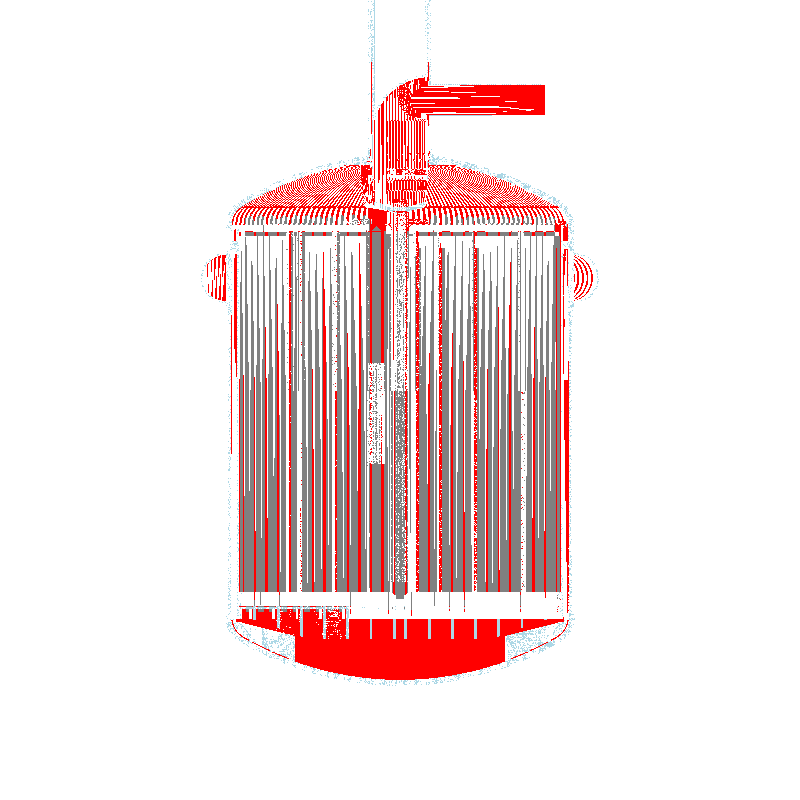

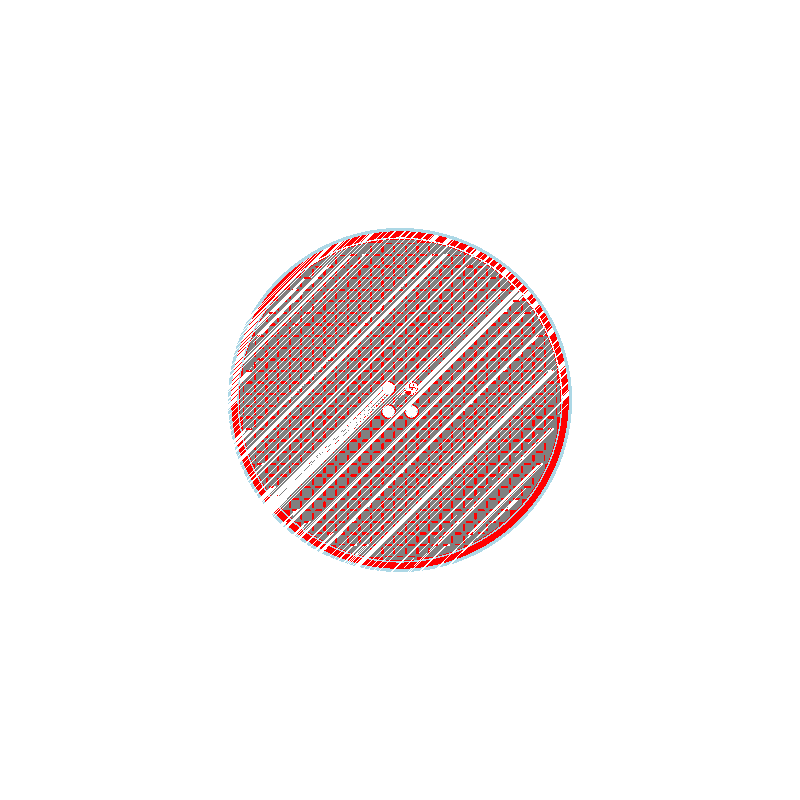

In [5]:
xwidth = 350
yheight = 350
material_colors={salt:'red', inor:'lightblue', inconel:'blue',helium:'white',graphite:'gray'}
#xz plot
p1 = openmc.Plot()
p1.background='white'
p1.basis = 'xz'
p1.width = (xwidth,yheight)
p1.origin=(0,0,125)
p1.pixels = (800, 800)
p1.color_by = 'material'
p1.colors=material_colors
#xy plot
p2 = openmc.Plot()
p2.background='white'
p2.basis='xy'
p2.width=(xwidth, yheight)
p2.pixels = (800,800)
p2.origin=(0,0,100)
p2.color_by='material'
p2.colors=material_colors

plots=openmc.Plots([p1,p2])
openmc.plot_inline(plots)

Now we need to define som settings for our calculations.

First of all - we need to some neutrons to kick-start or chain reaction. In OpenMC this is doen by defining a source region. Here this is simply defined as being a region that encloses the MSRE core.

Next we define some settings for the Monte Carlo-computation, such as how many particles we would initially run with. 

After the members of the settings python object have been filled to our desires, we export this to a settings xml-file

In [6]:
# Create a neutron source for kick-starting
source_volume=openmc.stats.Box([-125,-125,0],[125,125,500], only_fissionable=True)
source = openmc.Source(space=source_volume)
source.angle=openmc.stats.Isotropic()

/home/efra/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [13]:

#openmc.config['cross_sections'] = '/home/efra/simulations/openmc/data/endfb-vii.1-hdf5/cross_sections.xml'
openmc.config['cross_sections'] = '/home/efra/simulations/openmc/data/endfb-viii.0-hdf5/cross_sections.xml'

In [14]:

openmc.config

{'cross_sections': PosixPath('/home/efra/simulations/openmc/data/endfb-viii.0-hdf5/cross_sections.xml')}

In [11]:
#Finally we build a settings object for OpenMC where we define parameters for the run.
settings = openmc.Settings()
settings.source = source
settings.batches = 20
settings.inactive = 5
settings.particles = 20000
settings.export_to_xml()

openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Now that we have a running model let's try to do some more useful work with and extract some data from the model. To do this we need to specify what information we want to extract before 
starting simulations. In many Monte Carlo particle transport codes, we add objects known as tallies to our models. In this respect OpenMC is no different.

We will add tallies to monitor the neutron flux, and the fission sites in volumes along the geomtrical slices through our reactor that we plotted earlier.

A tally needs to know what to measure and where to measure that. In OpenMC the "where" is known as a filter and the "what" is known as a score.
In or case we'd like to spatially resolve the flux so we first generate mesh object as filters and then add that to tally objects. In addtion we assign a list of scores to the score-member of the tallies. Lastly (as always) we export this to an xml-file which will be read by OpenMC.

In [12]:
mesh1=openmc.RegularMesh()
mesh1.dimension =  [400,400,1]
mesh1.lower_left = [-125, -125, 90]
mesh1.upper_right = [125, 125, 110]
mesh1_filter = openmc.MeshFilter(mesh1)

mesh2=openmc.RegularMesh()
mesh2.dimension =  [400,1,400]
mesh2.lower_left = [-175, -10, -50]
mesh2.upper_right = [175,  10, 400]
mesh2_filter = openmc.MeshFilter(mesh2)

t1 = openmc.Tally(name='flux1')
t1.filters =[mesh1_filter]
t1.scores = ['flux','fission']

t2 = openmc.Tally(name='flux2')
t2.filters =[mesh2_filter]
t2.scores = ['flux','fission']

tallies=openmc.Tallies([t1,t2])
tallies.export_to_xml()

We have to re-run our simulation after generating the ```tallies.xml``` file.

Note that we forcibly remove the _old_ datafiles first.

In [13]:
import os
os.system("rm -f summary.h5 statepoint.20.h5")
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

After the run has finished the data we are after resides in the "statepoint" file that OpenMC saves.
In the below code, we will open that and extract the mean values for neutron flux.

In [14]:
sp=openmc.StatePoint('statepoint.20.h5')

tl1=sp.get_tally(name='flux1')
tl2=sp.get_tally(name='flux2')

flux1=tl1.get_slice(scores=['flux'])
flux2=tl2.get_slice(scores=['flux'])

flux1.mean.shape=(400,400)
flux2.mean.shape=(400,400)

The last 2 lines are necessary to reshape the flux maps into a 400x400 grid.

In the end we plot the maps using matplotlib

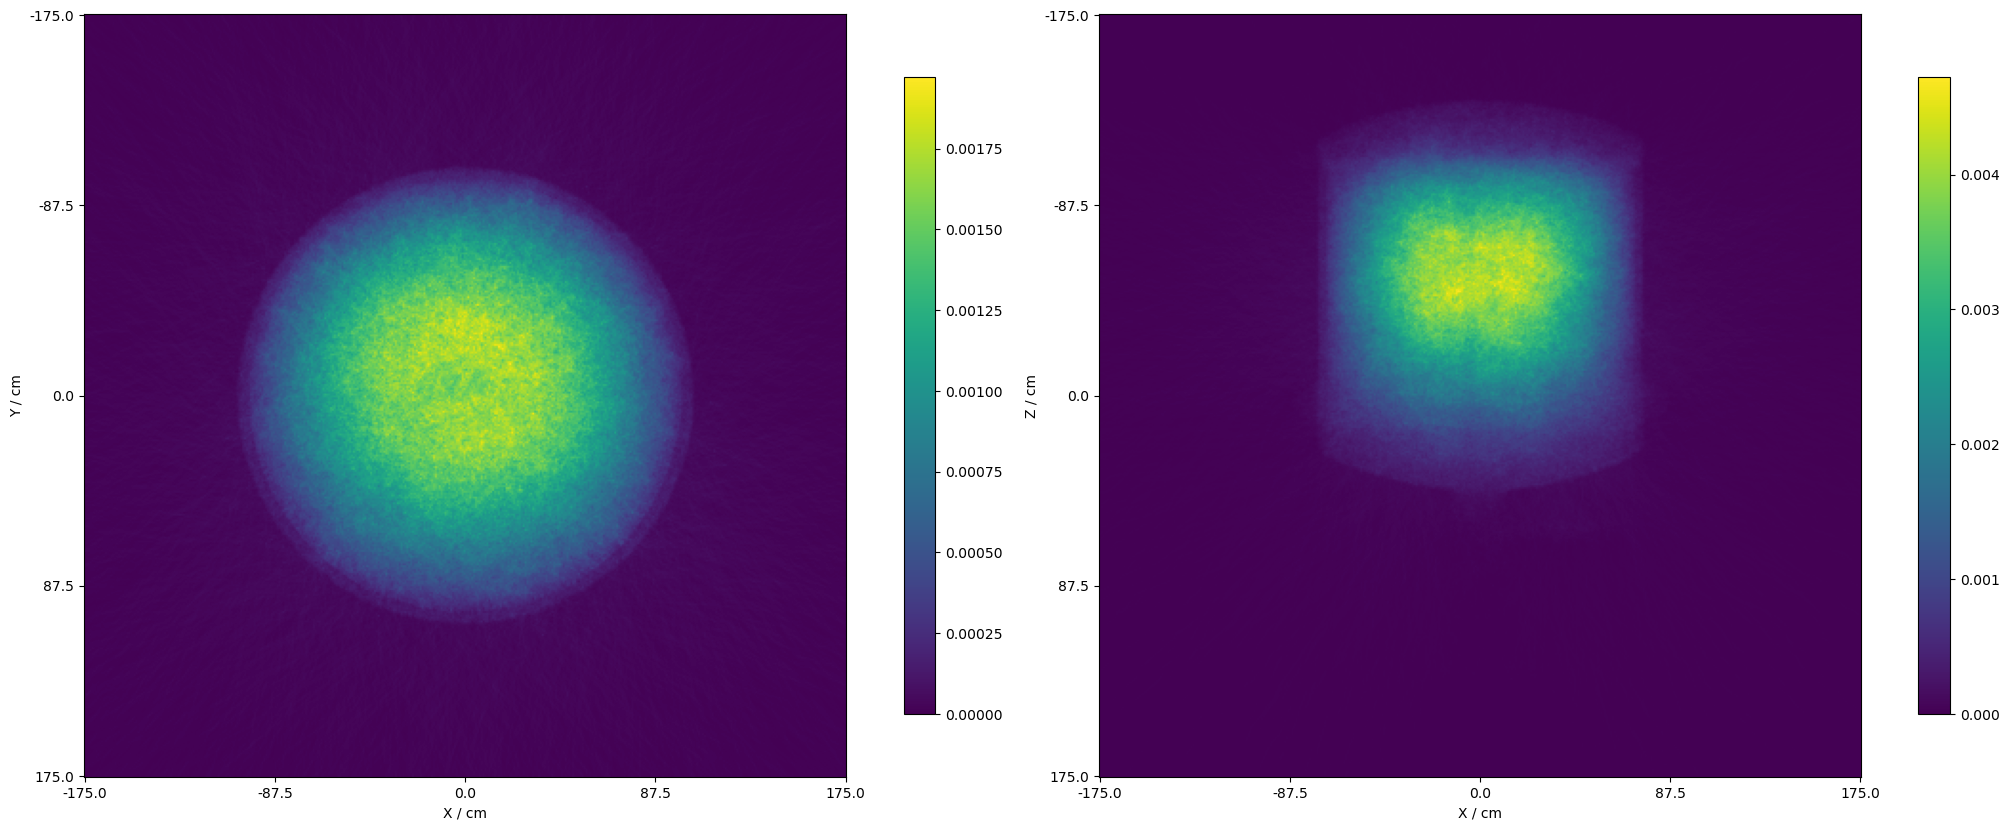

In [15]:
import matplotlib.pyplot as plt
import numpy as np
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,16), constrained_layout=True)

ax1.set_xticks(np.arange(0,401,399/4))
ax1.set_xticklabels(np.arange(-175,176,350./4))
ax2.set_xticks(np.arange(0,400,399/4))
ax2.set_xticklabels(np.arange(-175,176,350./4))
ax1.set_yticks(np.arange(0,400,399/4))
ax1.set_yticklabels(np.arange(-175,176,350./4))
ax2.set_yticks(np.arange(0,400,399/4))
ax2.set_yticklabels(np.arange(-175,176,350./4))
ax1.set_xlabel('X / cm')
ax1.set_ylabel('Y / cm')

ax2.set_xlabel('X / cm')
ax2.set_ylabel('Z / cm')
im1=ax1.imshow(flux1.mean)
fig.colorbar(im1,ax=ax1,shrink=0.4)
im2=ax2.imshow(flux2.mean)
fig.colorbar(im2,ax=ax2,shrink=0.4)

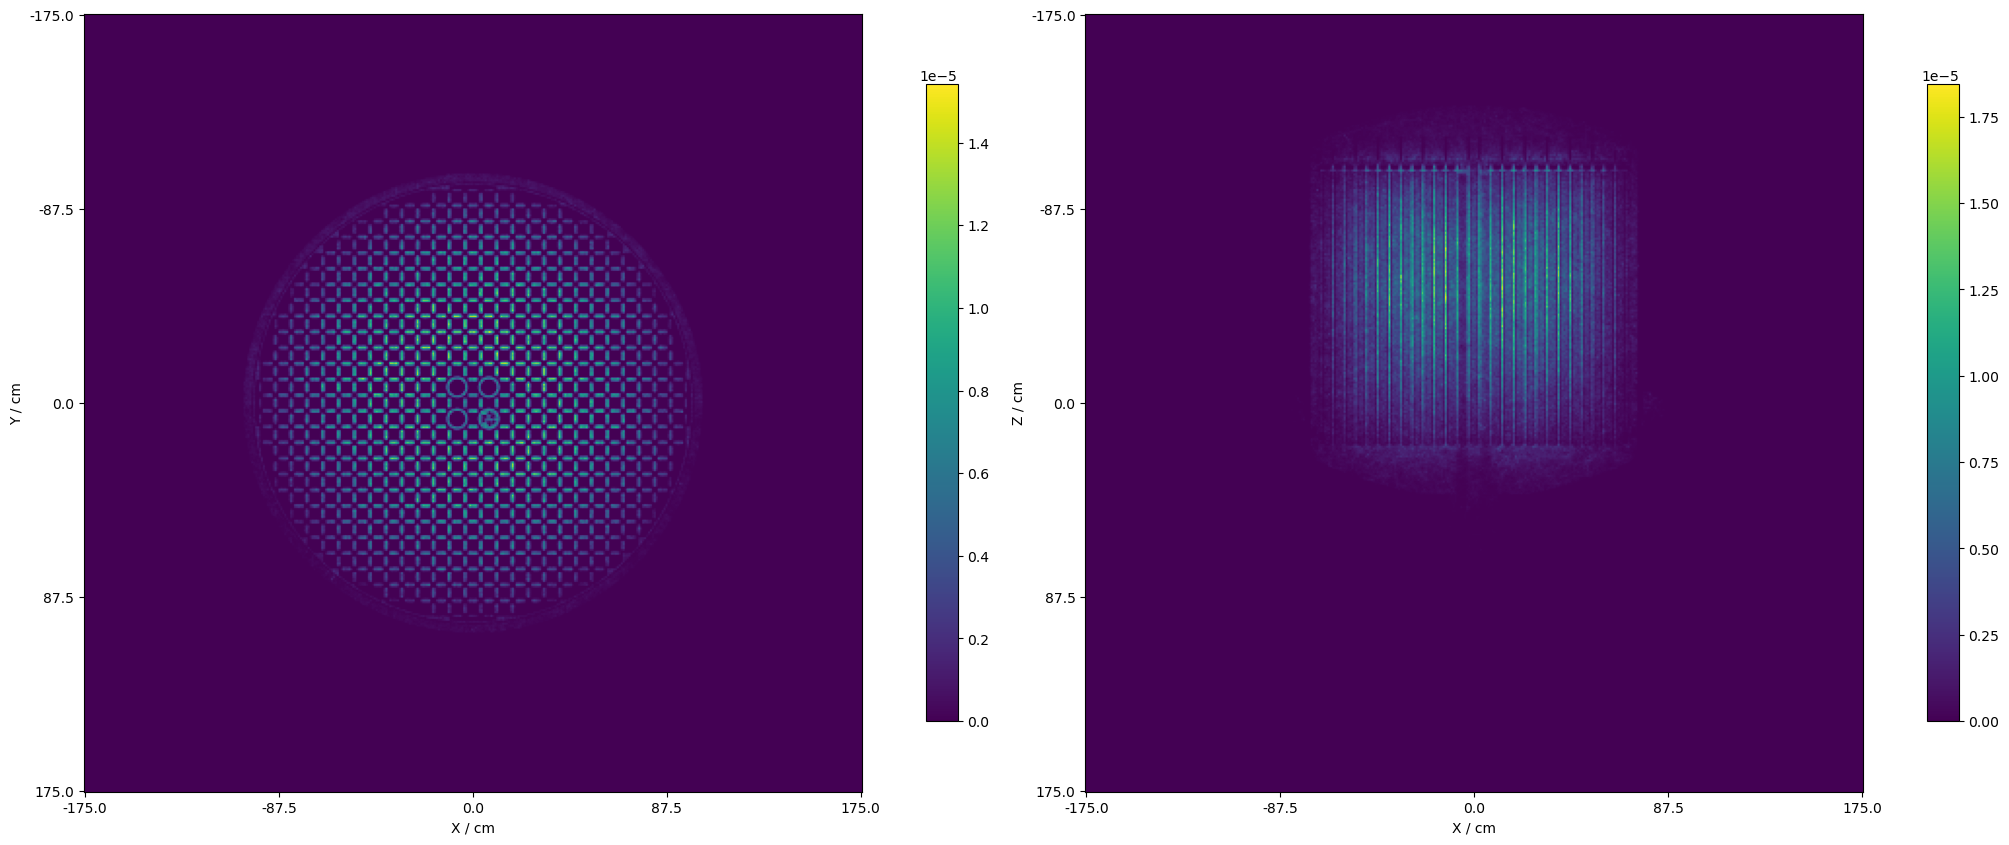

In [16]:
#Similarly we can plot fission reactions:

fission1=tl1.get_slice(scores=['fission'])
fission2=tl2.get_slice(scores=['fission'])

fission1.mean.shape=(400,400)
fission2.mean.shape=(400,400)

fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,16), constrained_layout=True)

ax1.set_xticks(np.arange(0,401,399/4))
ax1.set_xticklabels(np.arange(-175,176,350./4))
ax2.set_xticks(np.arange(0,400,399/4))
ax2.set_xticklabels(np.arange(-175,176,350./4))
ax1.set_yticks(np.arange(0,400,399/4))
ax1.set_yticklabels(np.arange(-175,176,350./4))
ax2.set_yticks(np.arange(0,400,399/4))
ax2.set_yticklabels(np.arange(-175,176,350./4))
ax1.set_xlabel('X / cm')
ax1.set_ylabel('Y / cm')

ax2.set_xlabel('X / cm')
ax2.set_ylabel('Z / cm')
im1=ax1.imshow(fission1.mean)
fig.colorbar(im1,ax=ax1,shrink=0.4)
im2=ax2.imshow(fission2.mean)
fig.colorbar(im2,ax=ax2,shrink=0.4)

Suppose we now would like to see what the energy spectrum of the neutrons generated in our reactor is. To explore this we will add another talliy to our simulation. This time however, instead of a spatial regular mesh, the tally will have an energy filter. Furthermore, we restrict the tally to neutron flux and fission events within the fuel salt, by means of a material filter. Unfortunately to fill the new tally we have to re-run the simulation.

In [17]:
#define a lograrithmic binning from 1keV to 10 MeV
ef=energyrange=openmc.EnergyFilter(np.logspace(3,7,200))
te = openmc.Tally(name='energy')

sf = openmc.MaterialFilter(salt)
te.filters =[ef,sf]
te.scores = ['flux','fission']

tallies.append(te)
tallies.export_to_xml()

In [18]:
os.system("rm -f summary.h5 statepoint.20.h5")
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [19]:
sp=openmc.StatePoint('statepoint.20.h5')

In [20]:
tl=sp.get_tally(name='energy')

e1=tl.get_slice(scores=['flux'])
e2=tl.get_slice(scores=['fission'])

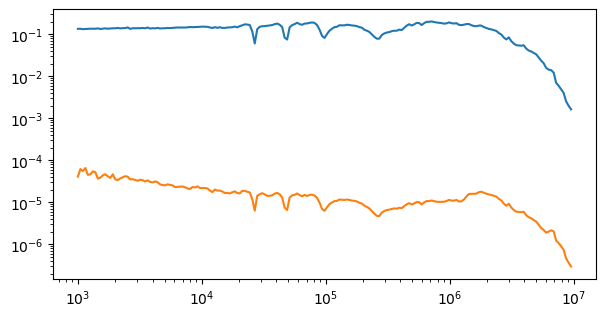

In [21]:
fig,ax=plt.subplots(figsize=(7,3.5),squeeze=True)
ax.plot(ef.values[:199],e1.mean[:,0,0])
ax.plot(ef.values[:199],e2.mean[:,0,0])
ax.set_xscale('log')
ax.set_yscale('log')

A reactor with a k_{eff} significantly higher than 1 is likely not what you want. Therefore we need to modify our initial model to also include a set of control rods. In the MSRE these rods consisted of three sets of cylindrical elements made from a Al_2O_3/Gd_2O_3-mixture. These absorb neutrons to "dampen" the nuclear process - something also known as poisoning.
The cylindrical elements were stacked to form the control rods (~=80''), which can be inserted into the reactor core in 3 of the 4 voids visible in the centre of the XZ-geometry of the reactor.

To run our reactor model with control-rods we will now simply point openmc at a different geometry-file, and append the missing materials to the materials list. To visualize we also add tallies to track the absorption.

In [10]:
#geometry
import os
import openmc

os.system('rm -f materials.xml geometry.xml tallies.xml')
h5m_filepath="msre_control_out.h5m"
dag_univ = openmc.DAGMCUniverse(h5m_filepath)
geom = openmc.Geometry(root=dag_univ)
geom.export_to_xml()

graphite=openmc.Material(name='graphite')
graphite.add_element('C',1.0,'ao')
graphite.set_density('g/cc',2.26)

#Hastelloy N / INOR-8 nominal material composition from
#ORNL-TM-4189
inor=openmc.Material(name='inor')
inor.add_element('Ni',0.72)
inor.add_element('Mo',0.16)
inor.add_element('Cr',0.07)
inor.add_element('Fe',0.05)
inor.set_density('g/cc',9)

# LiF,BeF2,UF4,ZrF4 [0.67,0.23,0.05,0.0079] mol % @ 33% enrichment 
molar_comp={'LiF':0.67,'BeF2':0.23, 'ZrF4':0.05, 'UF4':0.0079}
enrichment=0.3333
salt=openmc.Material(name='salt')
salt.add_element('F',molar_comp['LiF']*1/2+molar_comp['BeF2']*2/3+molar_comp['ZrF4']*4/5+molar_comp['UF4']*4/5,'ao')
salt.add_nuclide('Li7',molar_comp['LiF']*1/2,'ao')
salt.add_element('Be',molar_comp['BeF2']*1/3,'ao')
salt.add_element('Zr',molar_comp['ZrF4']*1/5,'ao')
salt.add_nuclide('U235',enrichment*molar_comp['UF4']*1/5,'ao')
salt.add_nuclide('U238',(1-enrichment)*molar_comp['UF4']*1/5,'ao')
salt.set_density('g/cc',2.2)

# The natural isotopes have been used for this alloy
# The density is set to that of Ni.
inconel=openmc.Material(name='inconel')
inconel.add_element('Ni',0.72,'ao')
inconel.add_element('Cr',0.20,'ao')
inconel.add_element('Fe',0.08,'ao')
inconel.set_density('g/cc',8.9)

helium=openmc.Material(name='helium')
helium.add_nuclide('He4',1.0,'ao')
helium.set_density('g/cc',1.0e-4)


b_w_conc={'Al2O3':0.3,'Gd2O3':0.7} # Wt. (D. Shen et.al. Nucl. Sc. & Eng., v. 195, pp. 825, 2021)
A_w={'Al':26.9815385,'Gd':157.25, 'O':15.99} #g/mol, (Webelements.com)
rho={'Al2O3':3.987,'Gd2O3':7.07} # g /cc, (Wikipedia: Aluminium_oxide & Gadolinium(III)_oxide)
b_mol_w={'Al2O3':2*A_w['Al']+ 3*A_w['O'],'Gd2O3':2*A_w['Gd']+3*A_w['O']}
bush_mol_comp={'Al2O3':(b_w_conc['Al2O3']/b_mol_w['Al2O3'])/( b_w_conc['Al2O3']/b_mol_w['Al2O3'] + b_w_conc['Gd2O3']/b_mol_w['Gd2O3'] ),
                'Gd2O3':(b_w_conc['Gd2O3']/b_mol_w['Gd2O3'])/( b_w_conc['Al2O3']/b_mol_w['Al2O3'] + b_w_conc['Gd2O3']/b_mol_w['Gd2O3'] )}

bush=openmc.Material(name='bush')
bush.add_element('Al',2/5*bush_mol_comp['Al2O3'],'ao')
bush.add_element('Gd',2/5*bush_mol_comp['Gd2O3'],'ao')
bush.add_element('O',3/5*bush_mol_comp['Al2O3']+3/5*bush_mol_comp['Gd2O3'],'ao')
bush.set_density('g/cc',b_w_conc['Al2O3']*rho['Al2O3'] +b_w_conc['Gd2O3']*rho['Gd2O3'] )


mesh1=openmc.RegularMesh()
mesh1.dimension =  [400,400,1]
mesh1.lower_left = [-125, -125, 90]
mesh1.upper_right = [125, 125, 110]
mesh1_filter = openmc.MeshFilter(mesh1)

mesh2=openmc.RegularMesh()
mesh2.dimension =  [400,1,400]
mesh2.lower_left = [-175, -10, -50]
mesh2.upper_right = [175,  10, 400]
mesh2_filter = openmc.MeshFilter(mesh2)

t1 = openmc.Tally(name='flux1')
t1.filters =[mesh1_filter]
t1.scores = ['flux','fission','absorption']

t2 = openmc.Tally(name='flux2')
t2.filters =[mesh2_filter]
t2.scores = ['flux','fission','absorption']

tallies=openmc.Tallies([t1,t2])
tallies.export_to_xml()


materials=openmc.Materials([helium,salt,graphite,inconel,inor,bush])
materials.export_to_xml()

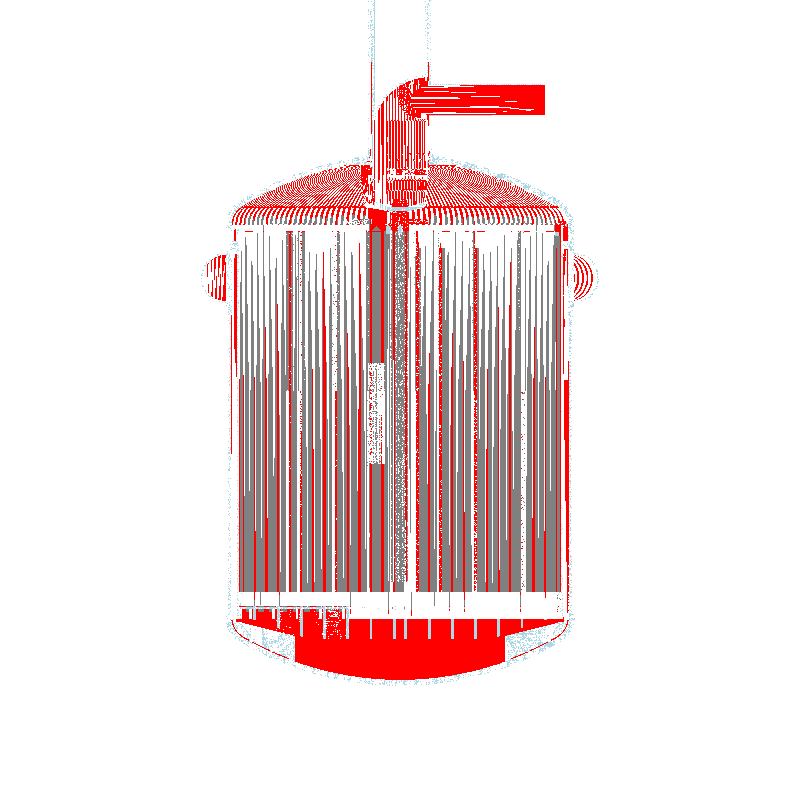

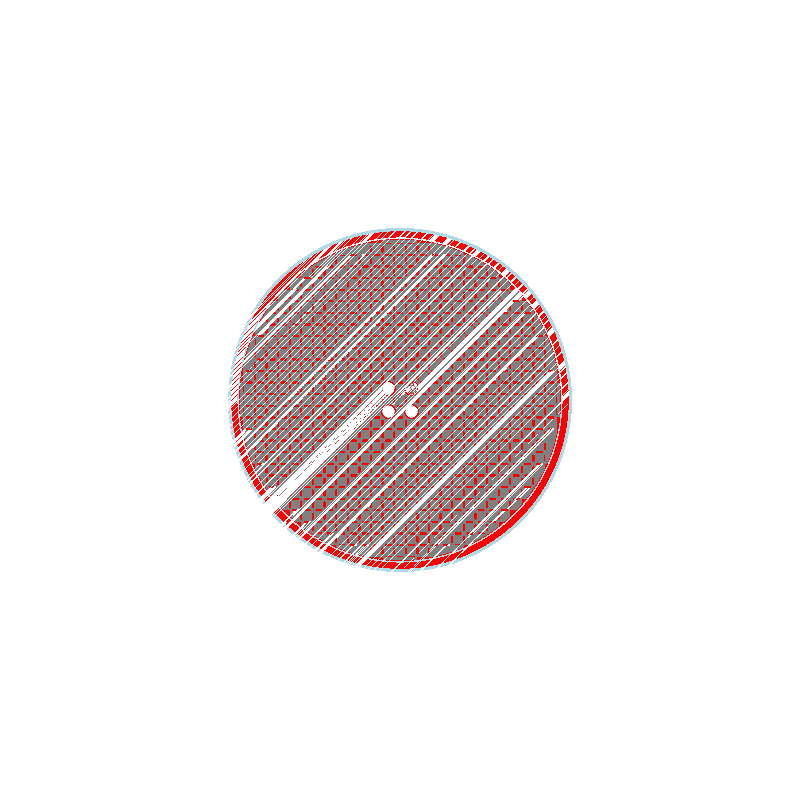

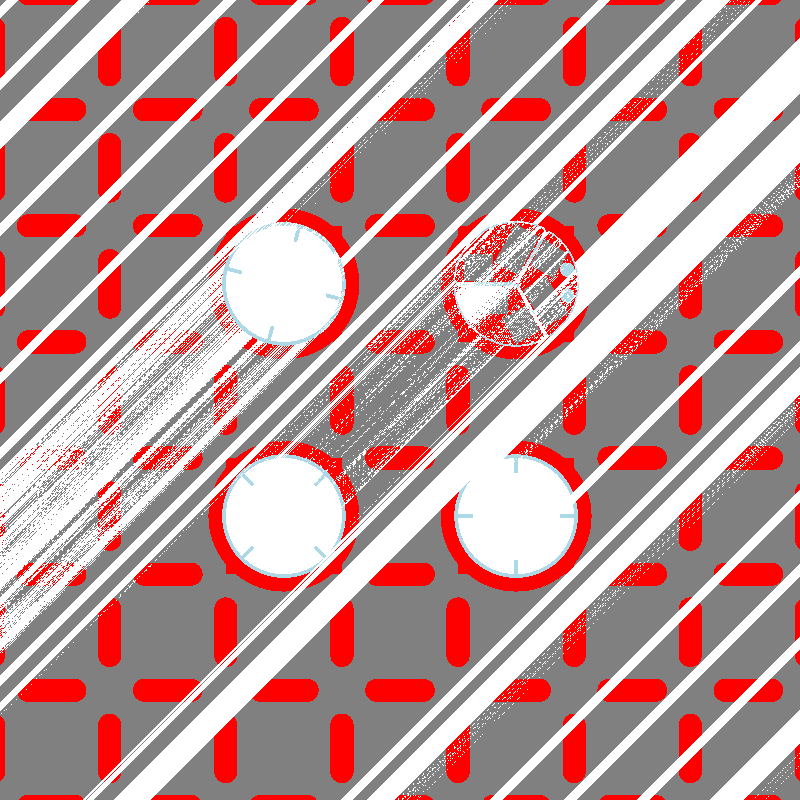

In [11]:
xwidth = 350
yheight = 350
material_colors={salt:'red', inor:'lightblue', inconel:'blue',helium:'white',graphite:'gray',bush:'purple'}
#xz plot
p1 = openmc.Plot()
p1.background='white'
p1.basis = 'xz'
p1.width = (xwidth,yheight)
p1.origin=(0,0,125)
p1.pixels = (800, 800)
p1.color_by = 'material'
p1.colors=material_colors
#xy plot
p2 = openmc.Plot()
p2.background='white'
p2.basis='xy'
p2.width=(xwidth, yheight)
p2.pixels = (800,800)
p2.origin=(0,0,100)
p2.color_by='material'
p2.colors=material_colors

p3 = openmc.Plot()
p3.background='white'
p3.basis='xy'
p3.width=(xwidth/10, yheight/10)
p3.pixels = (800,800)
p3.origin=(0,0,100)
p3.color_by='material'
p3.colors=material_colors

plots=openmc.Plots([p1,p2,p3])
openmc.plot_inline(plots)

In [15]:
os.system("rm -f summary.h5 statepoint.20.h5")
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

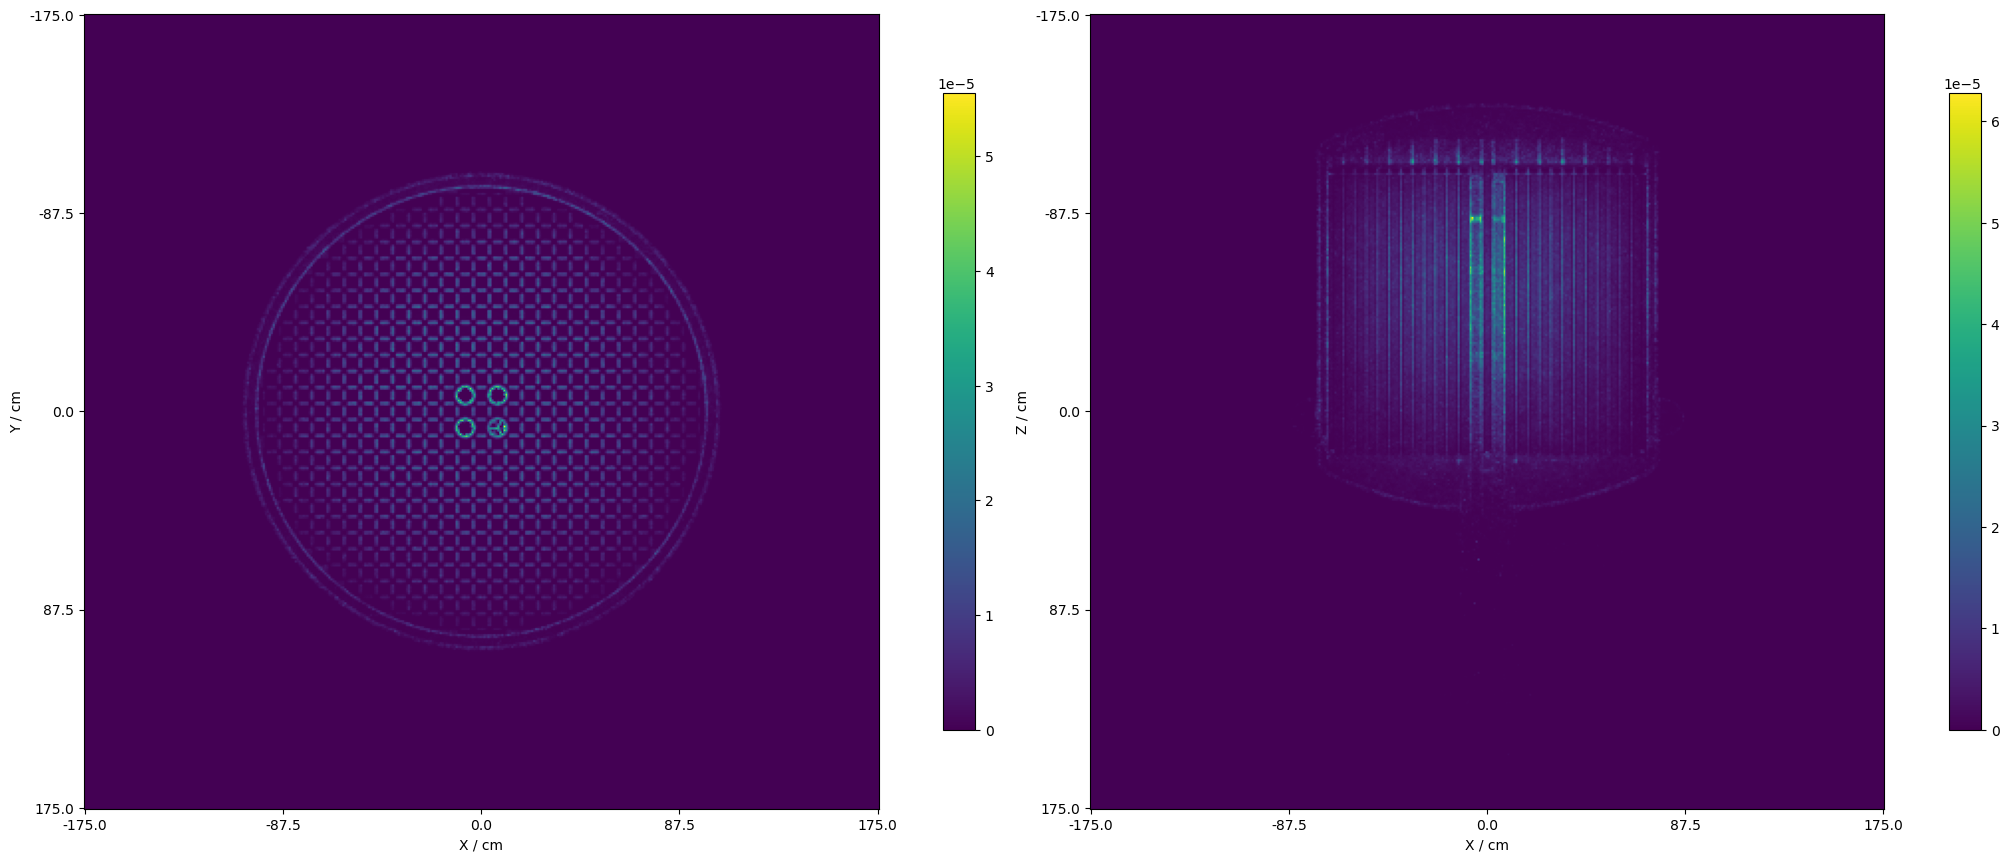

In [18]:
#Plot maps of the absorption
import matplotlib.pyplot as plt
import numpy as np

sp=openmc.StatePoint('statepoint.20.h5')

tl1=sp.get_tally(name='flux1')
tl2=sp.get_tally(name='flux2')

abs1=tl1.get_slice(scores=['absorption'])
abs2=tl2.get_slice(scores=['absorption'])

abs1.mean.shape=(400,400)
abs2.mean.shape=(400,400)

fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,16), constrained_layout=True)

ax1.set_xticks(np.arange(0,401,399/4))
ax1.set_xticklabels(np.arange(-175,176,350./4))
ax2.set_xticks(np.arange(0,400,399/4))
ax2.set_xticklabels(np.arange(-175,176,350./4))
ax1.set_yticks(np.arange(0,400,399/4))
ax1.set_yticklabels(np.arange(-175,176,350./4))
ax2.set_yticks(np.arange(0,400,399/4))
ax2.set_yticklabels(np.arange(-175,176,350./4))
ax1.set_xlabel('X / cm')
ax1.set_ylabel('Y / cm')

ax2.set_xlabel('X / cm')
ax2.set_ylabel('Z / cm')
im1=ax1.imshow(abs1.mean)
fig.colorbar(im1,ax=ax1,shrink=0.4)
im2=ax2.imshow(abs2.mean)
fig.colorbar(im2,ax=ax2,shrink=0.4)